In [1]:
import numpy as np
import cv2
import os
import glob
import torch
from density import PDM, Delta
from matplotlib import pyplot as plt
from PIL import Image
import pickle
from tqdm import tqdm
results_path="./result/D06_20210318083729_i100_3.pth"
results=torch.load(results_path)
bim_floor = cv2.imread("/home/gaobiaoli/dataset/base/target8F_L.png")
gt_path="/home/gaobiaoli/dataset/result/gt/D06_20210318083729"
mask_path="/home/gaobiaoli/dataset/base/mask-r"
H = np.load("/home/gaobiaoli/dataset/base/8F_D06.npy")
def cal_single_gt(gt_path,mask,H):
    gt_list=glob.glob(gt_path+"/*.png")
    gt_dict={}
    A_mask=np.sum(mask>0)
    for i in range(len(gt_list)):
        gt_r=cv2.imread(gt_list[i],0)
        gt = cv2.warpPerspective(
                gt_r, H, mask.shape[::-1], borderValue=0
            )
        A_gt=np.sum(gt*(mask>0)>0)
        gt_dict[int(os.path.basename(gt_list[i]).split(".")[0])]=A_gt/A_mask
    prev_value = None
    for key in sorted(gt_dict.keys()):
        if prev_value is not None and gt_dict[key] < prev_value:
            gt_dict[key] = prev_value
        prev_value = gt_dict[key]
    return gt_dict
def cal_single_pred(mask_list,flag_map):
    percentage_list=[]
    for mask in mask_list:
        A_mask=np.sum(mask>0)
        A_pred=np.sum(flag_map*(mask>0)>0)
        percentage_list.append(A_pred/A_mask)
    return percentage_list
gt_list=[]
mask_list=[]
for mask_id in range(1,11):
    if mask_id==9:
        continue
    mask=cv2.imread(os.path.join(mask_path,f"{mask_id}.png"),0)
    gt_dict=cal_single_gt(gt_path=gt_path,mask=mask,H=H)
    gt_list.append(gt_dict)
    mask_list.append(mask)
all_mask = np.sum(mask_list, axis=0)>0


In [ ]:
#从头开始
ids=range(len(results))
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
density=np.zeros(bim_floor.shape[:2],dtype=np.float32)
pdm=PDM(density,alpha=1.2,frame_interval=100,T_need=30)
progress=[]
for i in tqdm(ids):
    delta.add_points(results[i])
    pdm.update_map(delta.get_raw(masked=True,process=True))
    map=pdm.get_PDM(clip=True)
    flag_map=pdm.get_flag()
    pred=cal_single_pred(mask_list,flag_map)
    progress.append(pred)

In [2]:
#key frame
ids=range(0,len(results),50)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
density=np.zeros(bim_floor.shape[:2],dtype=np.float32)
pdm=PDM(density,alpha=1,frame_interval=100,T_need=30)
progress=[]
x=[0]
for id in tqdm(ids):
    delta.add_points_list(results[id:id+50])
    pdm.update_map(delta.get_raw(masked=True,process=True))
    map=pdm.get_PDM(clip=True)
    flag_map=pdm.get_flag()
    pred=cal_single_pred(mask_list,flag_map)
    progress.append(pred)
    x.append(x[-1]+len(results[id:id+50]))
x.pop(0)

100%|██████████| 22/22 [00:27<00:00,  1.26s/it]


0

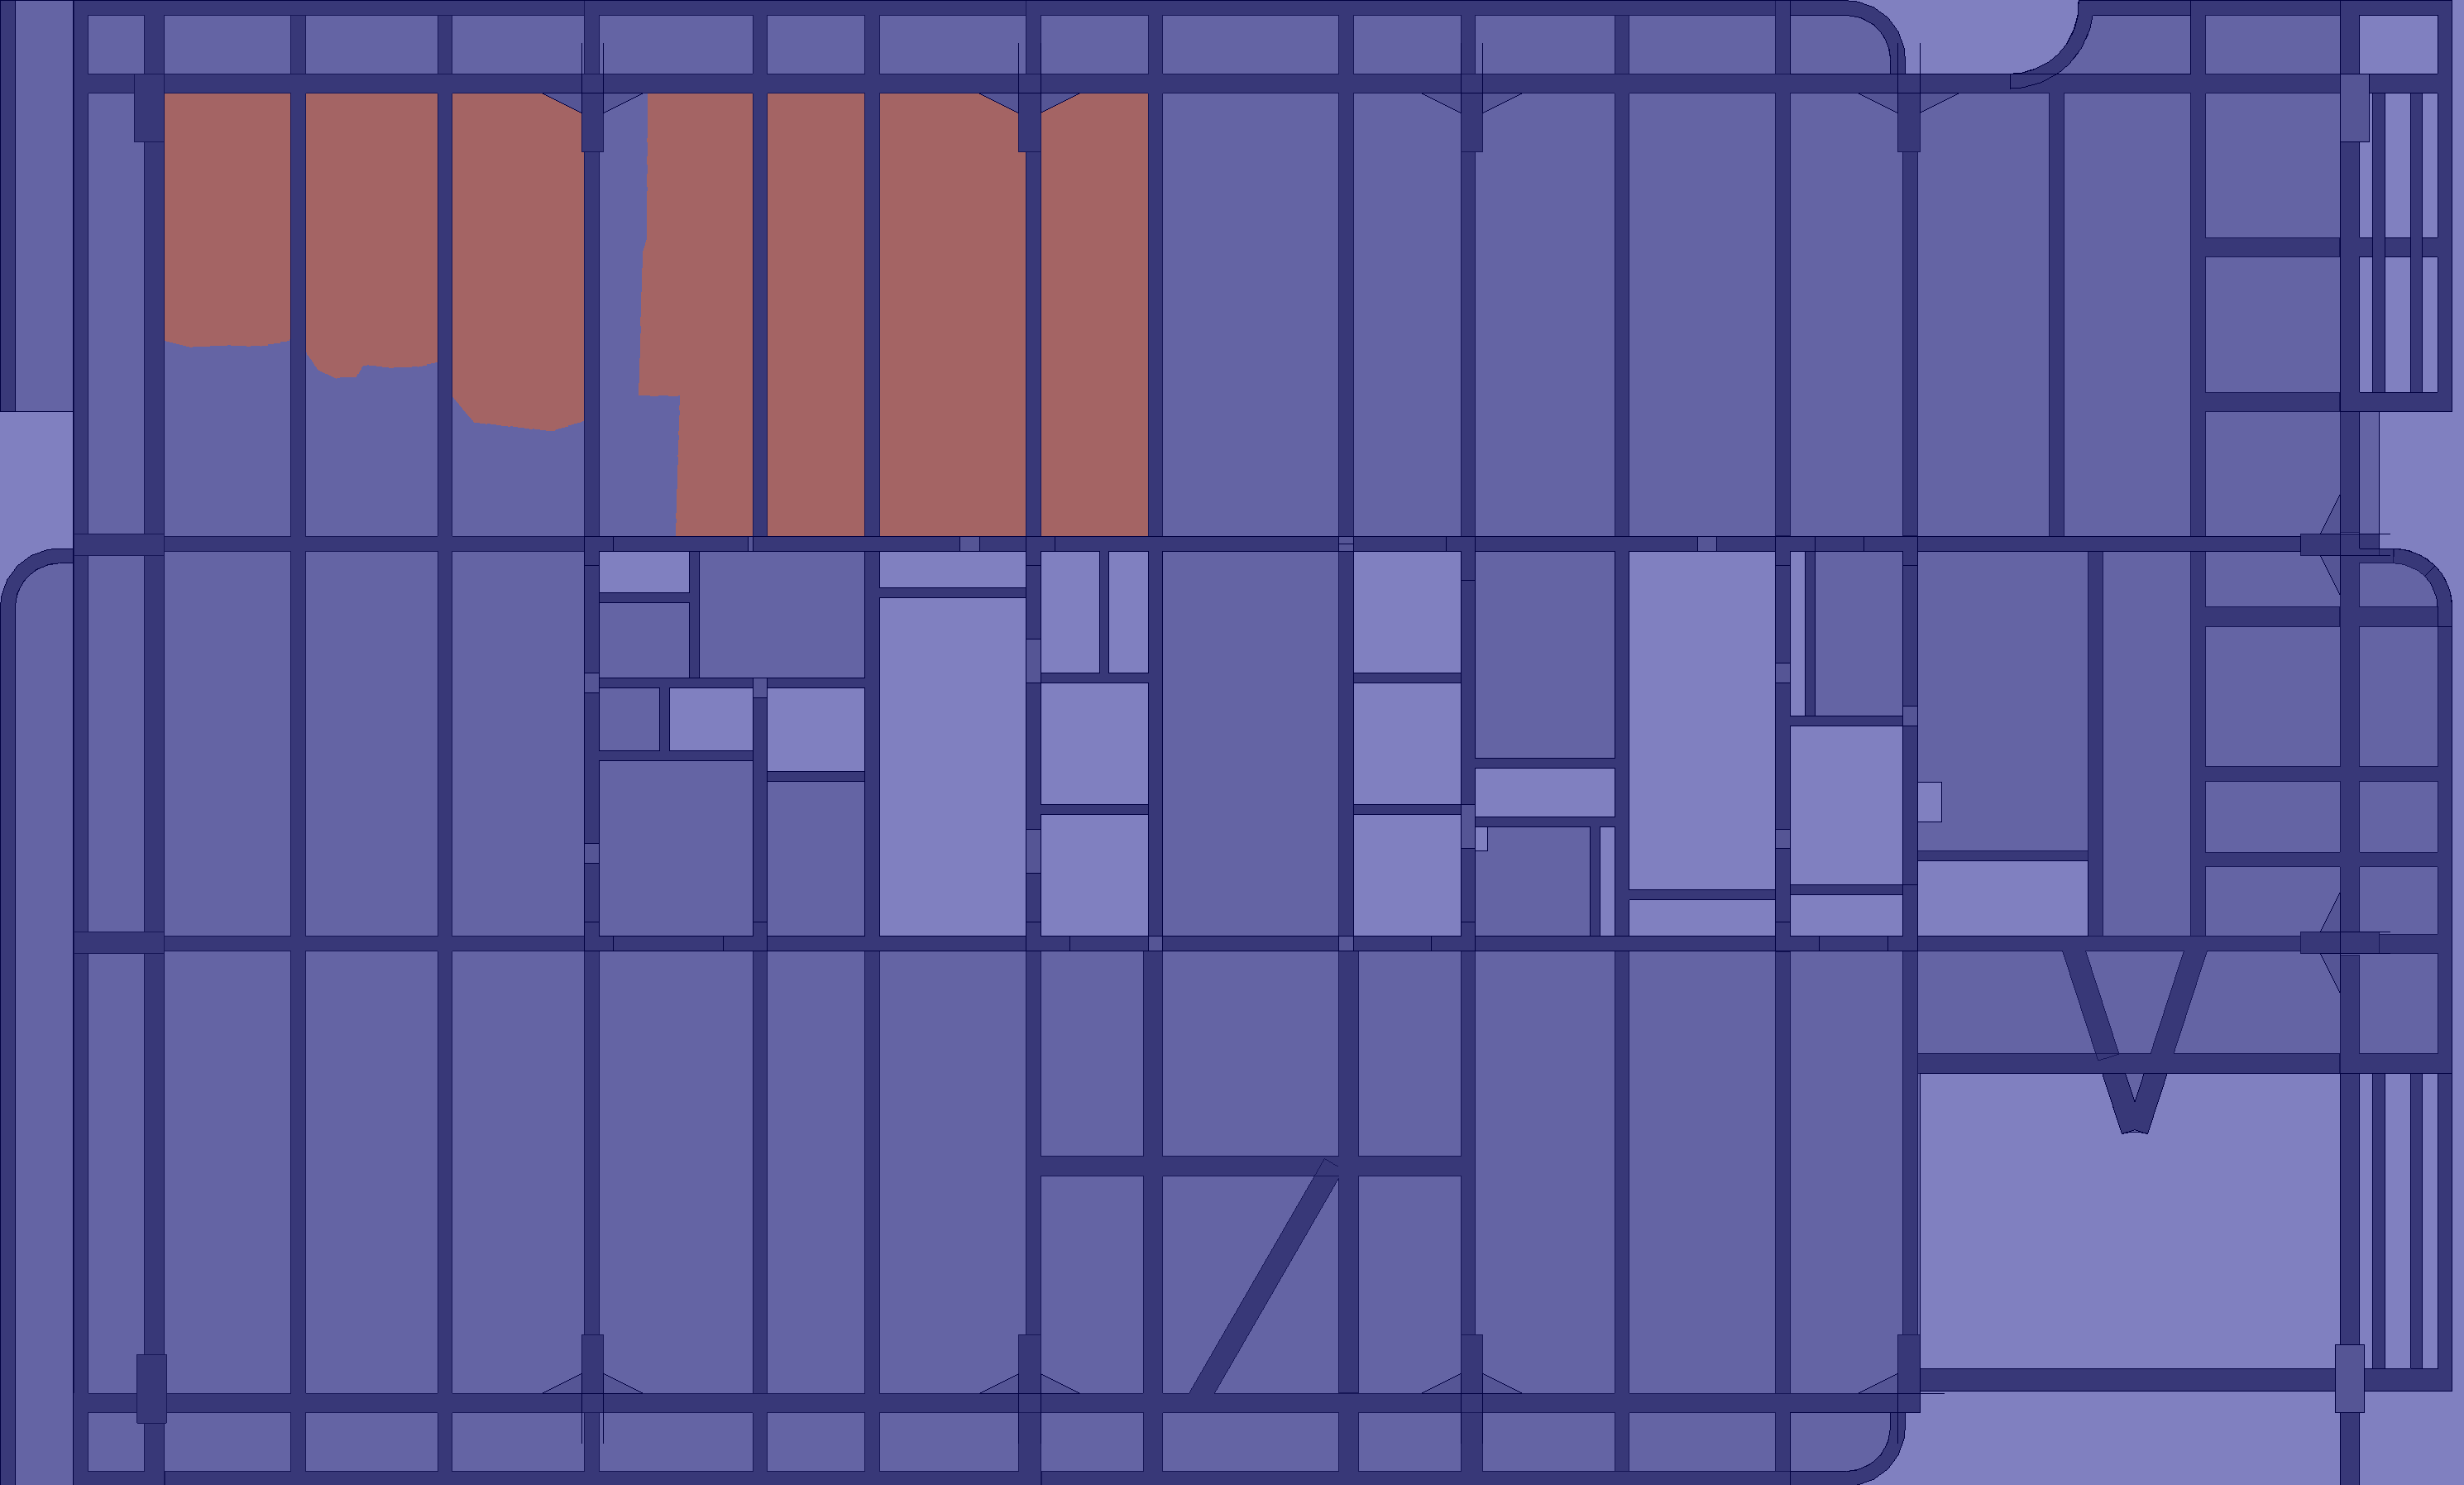

In [38]:
#plot
gt_png="/home/gaobiaoli/dataset/result/gt/D06_20210318083729/107500.png"
gt_png=(cv2.imread(gt_png,0)>0).astype(np.uint8)
gt_png = cv2.warpPerspective(
                gt_png, H, mask.shape[::-1], borderValue=0
            )
heatmapshow=None
heatmapshow = cv2.normalize(gt_png*all_mask,heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
fusion=cv2.addWeighted(heatmapshow,0.5,bim_floor,0.5,1)
fusion=cv2.cvtColor(fusion,cv2.COLOR_BGR2RGB)
Image.fromarray(fusion)


In [45]:
slab_progresses=[]
for slab_id in range(len(progress[0])):
    slab_p=[]
    for time_id in range(len(progress)):
        slab_p.append(progress[time_id][slab_id])
    slab_progresses.append(slab_p)
slab_progresses

[[0.0,
  0.0,
  0.0027176586325627153,
  0.0035415641908509593,
  0.003762911952779144,
  0.0050049188391539596,
  0.0050049188391539596,
  0.028184948352188884,
  0.09037137235612396,
  0.16385882931628135,
  0.26542056074766357,
  0.32675848499754057,
  0.38732169208066897,
  0.43240285292670927,
  0.48462862764387604,
  0.4863994097393015,
  0.48882193802262663,
  0.4940113133300541,
  0.49792179045745205,
  0.5102926709296606,
  0.5207820954254796,
  0.5992621741269061],
 [0.0,
  0.0,
  0.09148298360077588,
  0.16829483336272263,
  0.2386527949215306,
  0.28270146358666903,
  0.30216892964203845,
  0.36945864926820665,
  0.4390172221242579,
  0.4799976488567566,
  0.48050314465408805,
  0.48050314465408805,
  0.48052665608652206,
  0.48052665608652206,
  0.48052665608652206,
  0.4806559689649092,
  0.4917533650737671,
  0.4971022159525069,
  0.4989596191147946,
  0.5035913713042968,
  0.5750426144712867,
  0.6332216540292718],
 [0.007095733067539987,
  0.010619868052589111,
  0.057

/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[1534.2803955078125, 1628.999267578125, 2200.346923828125, 1417.3299560546875, 1313.7601318359375, 2718.955810546875, 1658.4259033203125, 17.799131393432617, 40.47842788696289]
[47429.0, 53587.0, 63111.0, 62509.0, 60061.0, 91957.0, 64143.0, 0.0, 1503.0]
[3.234899313727493, 3.0399150308435345, 3.4864713343602936, 2.2674014238824607, 2.1873763870663785, 2.9567687185824627, 2.585513467284524, inf, 2.69317550811463]


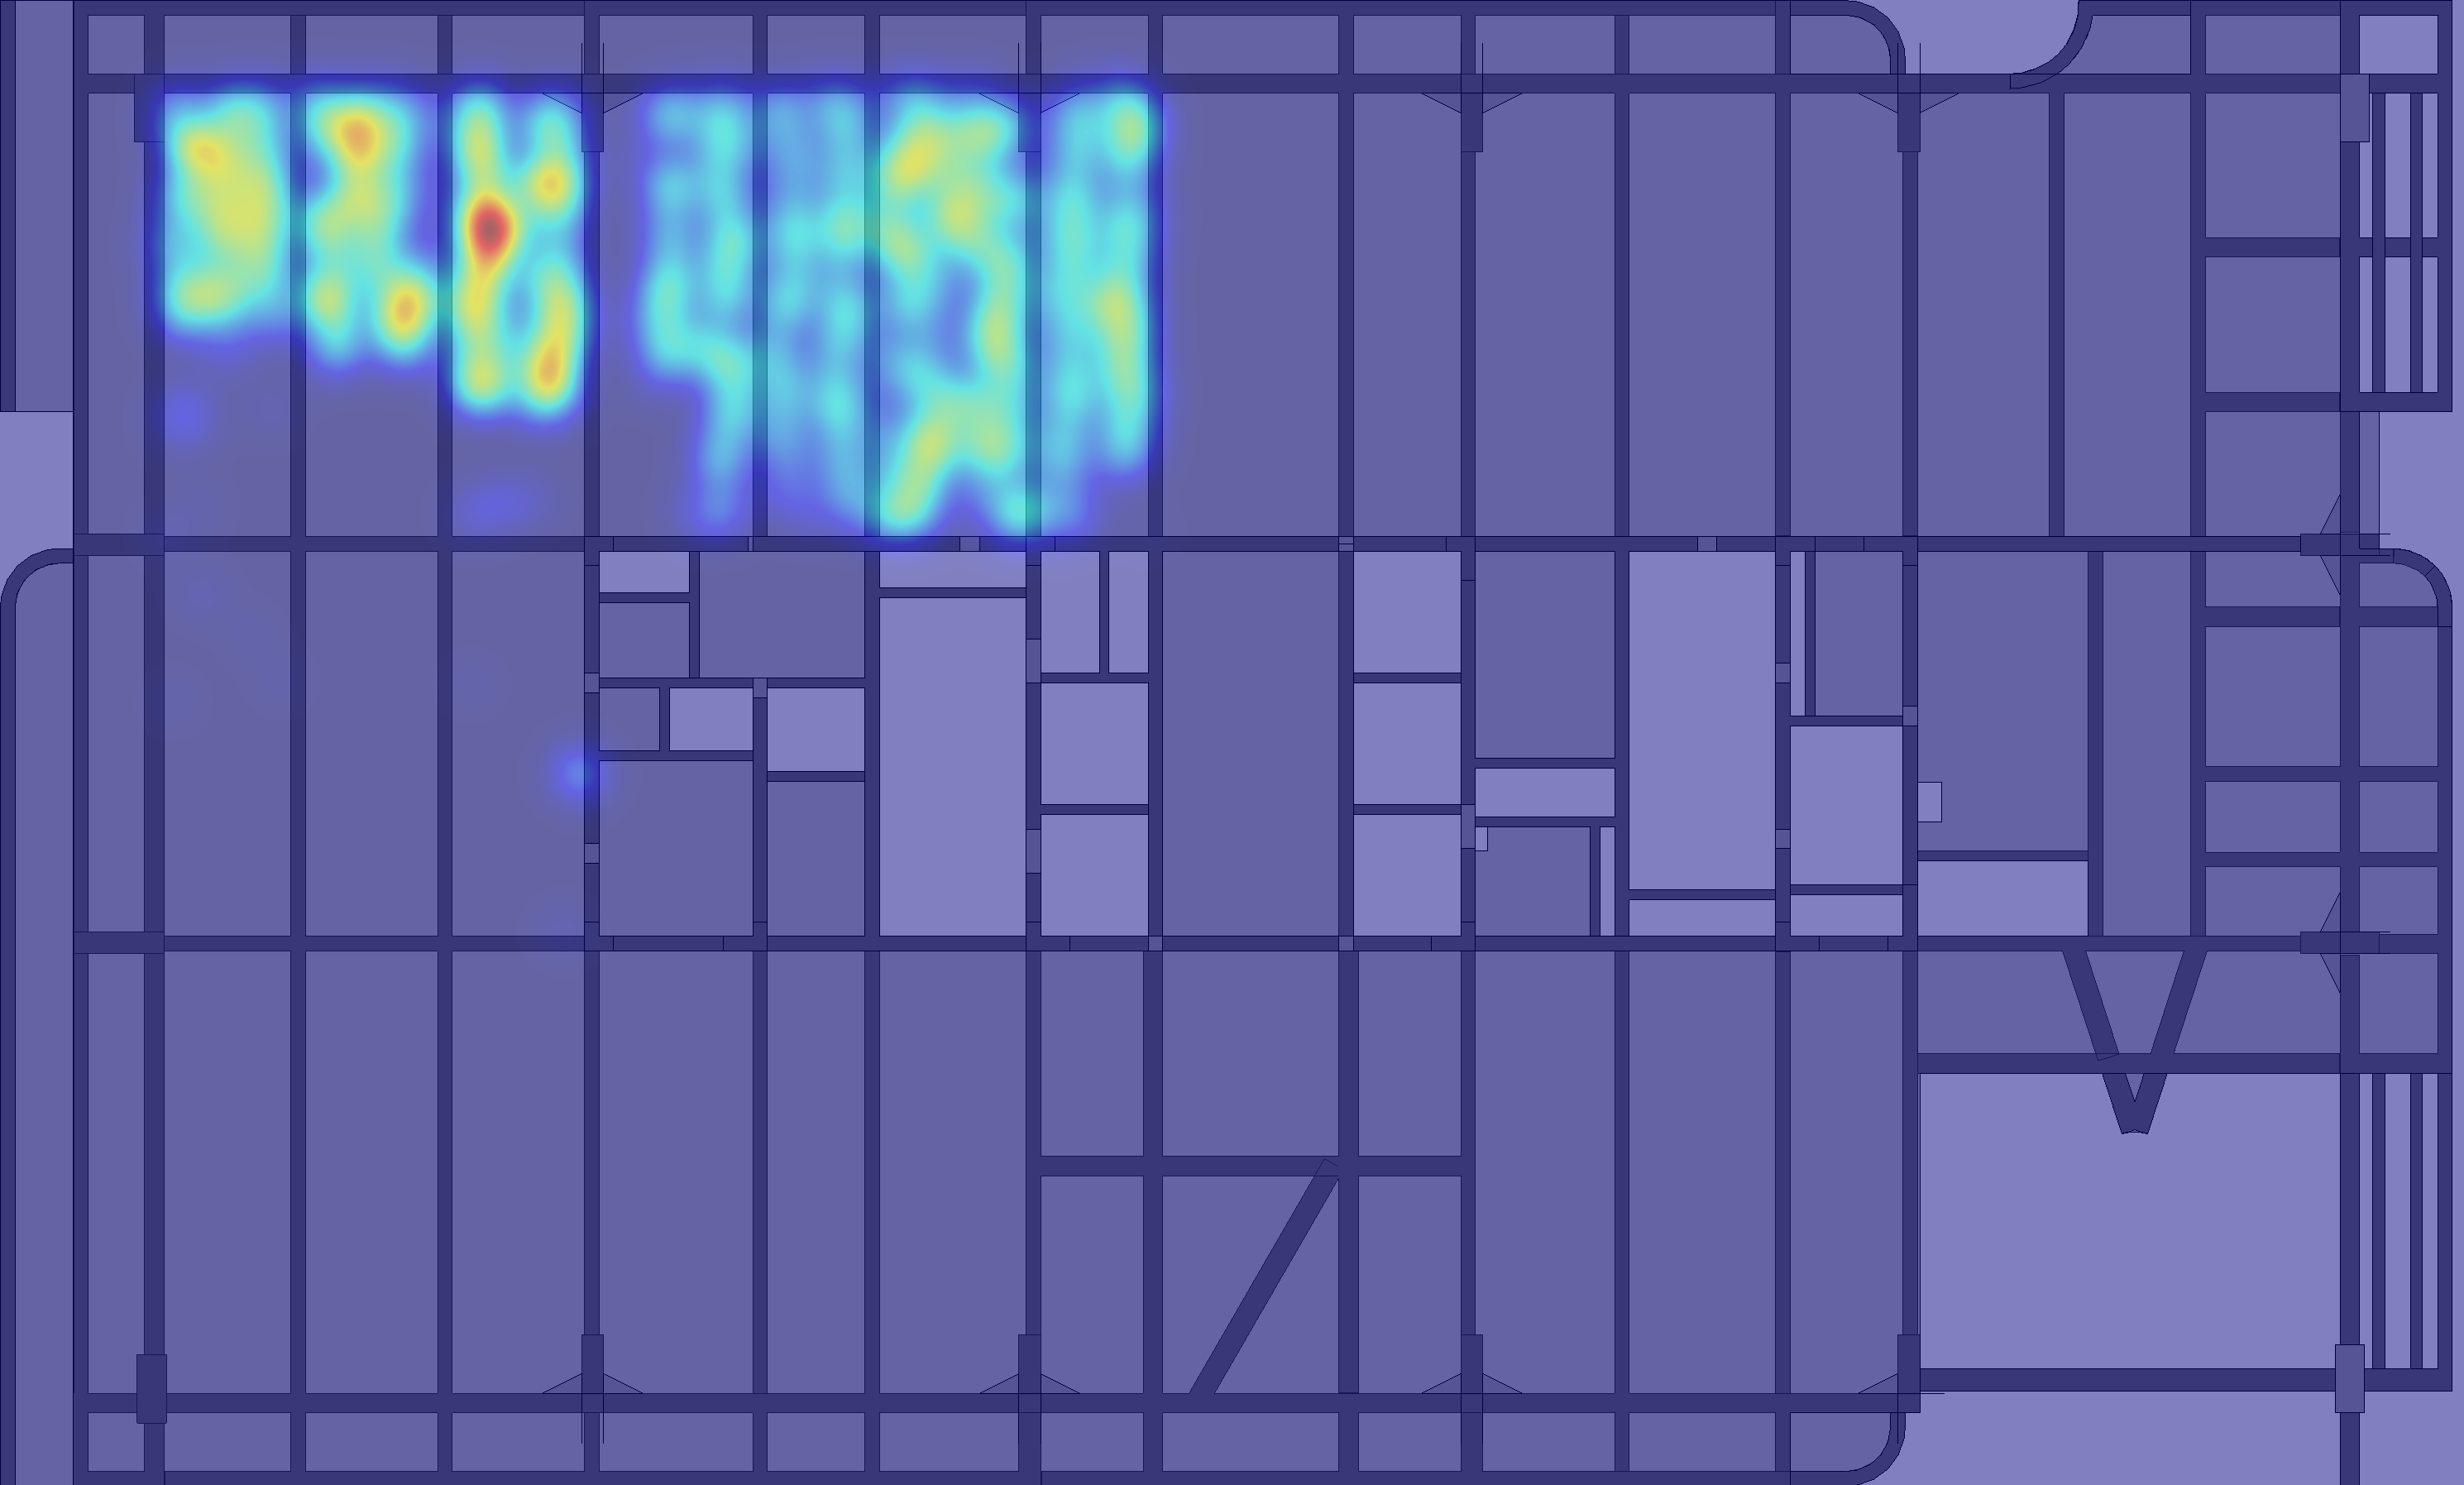

In [14]:
id=1077
pdm = PDM(density,alpha=1,frame_interval=100,T_need=30,sigma=25)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
delta.add_points_list(results[0:id-1])
map=delta.get_raw(masked=False,process=True)*all_mask
pdm.update_map(map)
map=pdm.get_PDM()

finished=pdm.get_flag()

time_consuming=[]
area=[]
productivity_area=[]
for mask in mask_list:
    time_consuming.append(np.sum(map*(mask>0)) * 4)
    area.append(np.sum(finished*(mask>0)))
    productivity_area.append(time_consuming[-1]/area[-1]*100)
print(time_consuming)
print(area)
print(productivity_area)
heatmapshow=None
heatmapshow = cv2.normalize(map,heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
fusion=cv2.addWeighted(heatmapshow,0.5,bim_floor,0.5,1)
fusion=cv2.cvtColor(fusion,cv2.COLOR_BGR2RGB)
Image.fromarray(fusion)

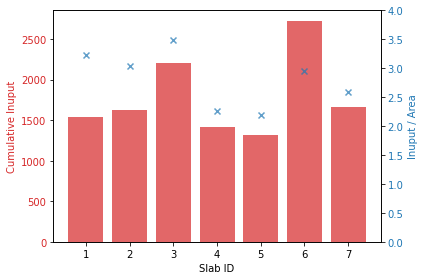

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
index = np.array([1, 2, 3, 4, 5, 6, 7])

# 绘图
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Slab ID')
ax1.set_ylabel('Cumulative Inuput', color=color)
ax1.bar(index, time_consuming[:7], color=color, label='Cumulative Time', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inuput / Area', color=color)
ax2.scatter(index, productivity_area[:7], color=color, marker='x', label='Productivity', alpha=0.7)
ax2.set_ylim([0, 4])
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(index)
ax1.set_xticklabels(index)

fig.tight_layout()
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.title('Cumulative Production Time vs Productivity')
# plt.show()
plt.savefig("/home/gaobiaoli/dataset/result/productivity.png",dpi=1000,bbox_inches='tight')


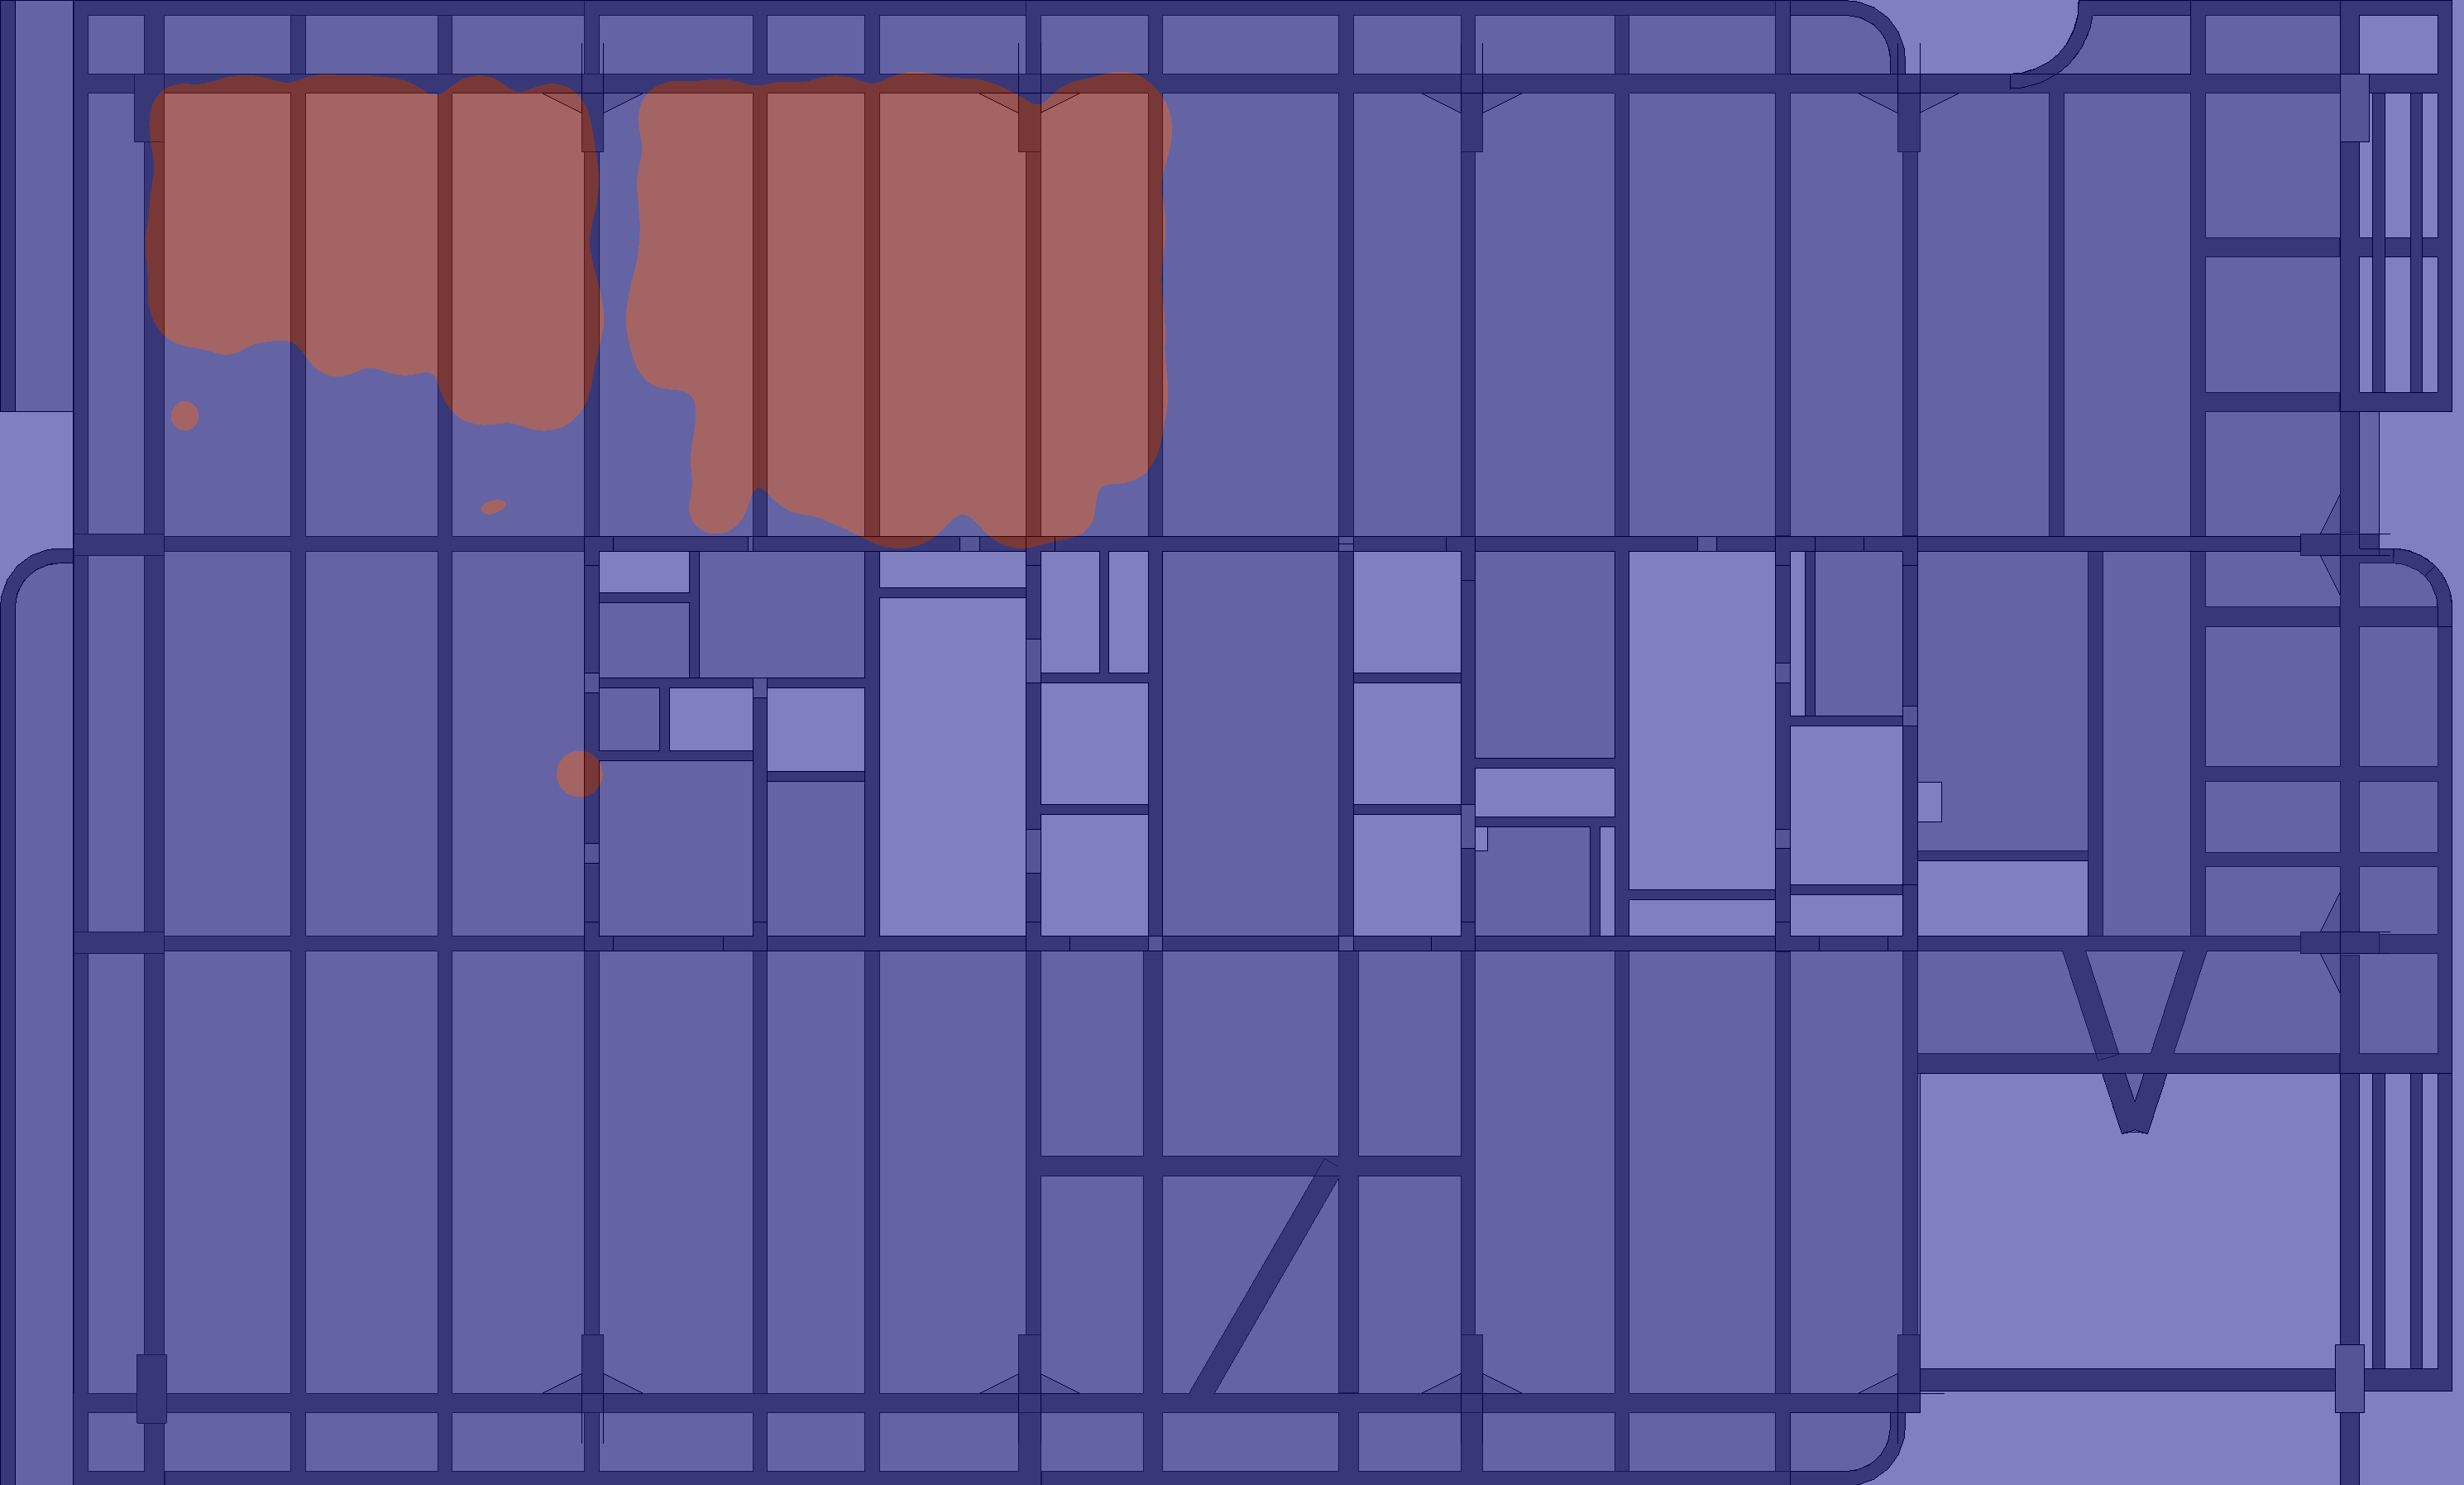

In [19]:
id=1077
pdm=PDM(density,alpha=1,frame_interval=100,T_need=30,sigma=25)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
delta.add_points_list(results[0:id-1])
map=delta.get_raw(masked=True,process=True)*all_mask
# Image.fromarray(delta.plot(delta=map))

pdm.update_map(map)
map=pdm.get_PDM(clip=True)
map=pdm.get_flag()
heatmapshow=None
heatmapshow = cv2.normalize(map,heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
fusion=cv2.addWeighted(heatmapshow,0.5,bim_floor,0.5,1)
fusion=cv2.cvtColor(fusion,cv2.COLOR_BGR2RGB)
Image.fromarray(fusion) #.save("/home/gaobiaoli/dataset/result/heat_map/500.png")

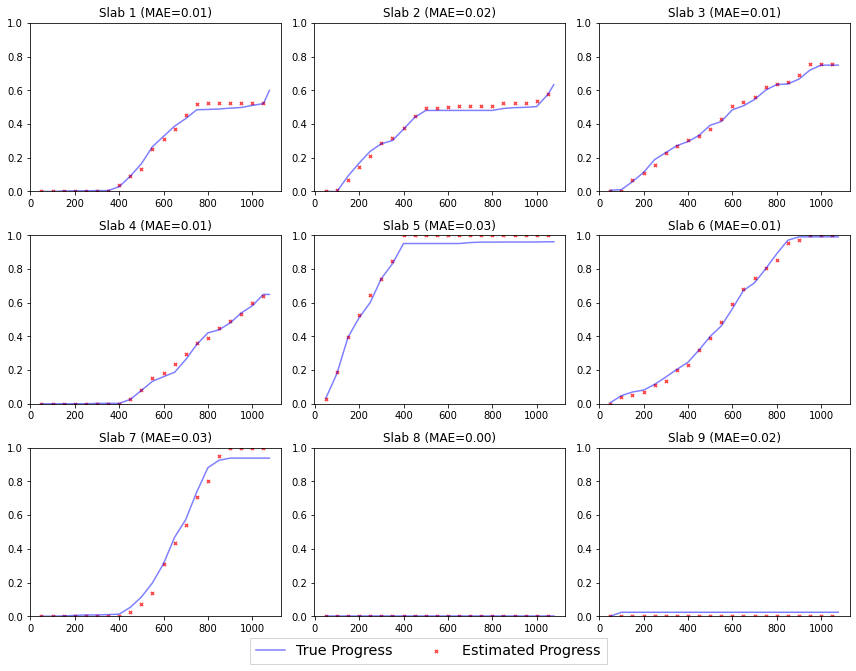

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 子图的行数和列数
rows = 3
cols = 3

# 每个子图的大小
subplot_width = 4
subplot_height = 3

# 计算整张图的大小
fig_width = cols * subplot_width
fig_height = rows * subplot_height

# 创建一个包含多个子图的图像，并设置大小
fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

# 通过循环在每个子图中绘制内容
for i in range(len(mask_list)):
    row = i // cols
    col = i % cols
    y = [pred[i] for pred in progress]
    axs[row, col].plot(x, y,alpha=0.5,color="blue")
    sc_x=[i/100 for i in gt_list[i].keys()]
    sc_y=list(gt_list[i].values())
    mae=0
    mre=0
    count=0
    for si in range(len(sc_x)):
        gt=sc_y[si]
        pred=y[x.index(sc_x[si])]
        mae += abs(gt - pred)
        if gt != 0:
            mre += abs((gt - pred) / gt)
            count += 1
    mae /= len(sc_x)
    mre /= count if count > 0 else 1 
    axs[row, col].scatter(sc_x,sc_y,alpha=0.7,color="red",s=10,marker="x")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].set_title(f"Slab {i+1} (MAE={mae:.2f})")
plt.tight_layout()
fig.legend(['True Progress', 'Estimated Progress'], loc='upper center', bbox_to_anchor=(0.5, 0.02), fancybox=False, shadow=False, ncol=2, fontsize='x-large')
plt.draw()
# plt.show()
plt.savefig("/home/gaobiaoli/dataset/result/heat_map/progress.png",dpi=1000,bbox_inches='tight')


In [4]:
progress

[[0.0,
  0.0,
  0.007095733067539987,
  0.0,
  0.03353302979471204,
  0.007047178438861692,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.010619868052589111,
  0.0003977805883072906,
  0.18033389248342518,
  0.04846952498789607,
  0.0,
  0.0,
  0.023557796573411408],
 [0.0027176586325627153,
  0.09148298360077588,
  0.05786938155584034,
  0.0004079800905715801,
  0.39583033788641264,
  0.0701705309591694,
  0.0018404101485473905,
  0.0,
  0.023557796573411408],
 [0.0035415641908509593,
  0.16829483336272263,
  0.11299776923442025,
  0.0004079800905715801,
  0.510887451074367,
  0.08163967938027866,
  0.004790908958123366,
  0.0,
  0.023557796573411408],
 [0.003762911952779144,
  0.2386527949215306,
  0.1890099197873653,
  0.0004079800905715801,
  0.6014857416726576,
  0.11529399106998763,
  0.007551524180944452,
  0.0,
  0.023557796573411408],
 [0.0050049188391539596,
  0.28270146358666903,
  0.23030281456167828,
  0.0027130676023010077,
  0.743286204968448,
  0.15882511162515467,
  0.007551